###### ETL Process: 
--> Import Python Package 
--> Connect to source database and define destination database in SQL server 
--> read csv file
--> concat existing data and new data
--> populate SQL table

In [246]:
import pandas as pd
import numpy as np
import os
file_path=''

In [247]:
import pyodbc
import urllib
import sqlalchemy

'''sources databases'''
params_p = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=DataWarehouse1;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_p = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_p))


params_s = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=DataWarehouse2;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_s = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_s))



'''destination databases'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [248]:
df=pd.read_excel(file_path+'data - Promotional Effectiveness Analysis.xlsx')
df.head()


,Year,week number,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,# Transactions that contained the product
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379


In [249]:
df.shape,df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Year                                       134 non-null    int64  
 1   week number                                134 non-null    int64  
 2   Product                                    134 non-null    object 
 3   Price                                      134 non-null    float64
 4   On Flyer?                                  134 non-null    object 
 5   Discount                                   134 non-null    float64
 6   Units                                      134 non-null    int64  
 7   Sales $                                    134 non-null    float64
 8   Gross Margin $                             134 non-null    float64
 9   # Transactions that contained the product  134 non-null    int64  
dtypes: float64(4), int64(4), o

((134, 10), None)

In [250]:
df.to_sql('retail',engine_datahub,if_exists='replace',index=False)

In [251]:
# drop duplicates - no duplicates
df.drop_duplicates(keep='first', inplace=True)
df.shape

(134, 10)

In [252]:
df_new = df.rename({'# Transactions that contained the product':'Num_Transact','week number':'week'},axis=1)
df_new.head()

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379


In [253]:
df_new.describe()

,Year,week,Price,Discount,Units,Sales $,Gross Margin $,Num_Transact
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,2021.223881,22.358209,5.381045,0.168657,22475.373134,100484.140299,24477.665632,14527.977612
std,0.418407,15.500377,1.684358,0.175327,16891.686295,50213.865512,10730.292069,5824.488856
min,2021.000000,1.000000,2.490000,0.000000,8381.000000,47484.840000,-23932.000000,8216.000000
25%,2021.000000,9.000000,3.990000,0.000000,9701.000000,66589.775000,22974.742500,9261.250000
50%,2021.000000,19.000000,4.990000,0.150000,13118.000000,73012.860000,24993.375000,12071.000000
75%,2021.000000,35.750000,6.790000,0.300000,32441.750000,131230.107500,32921.070000,21111.000000
max,2022.000000,52.000000,7.990000,0.500000,77200.000000,232605.030000,35631.740000,26439.000000


In [254]:
df_new['Sales/Transact'] = df_new['Sales $']/df_new['Num_Transact']
df_new['Margin/Transact']= df_new['Gross Margin $']/df_new['Num_Transact']
df_new['Cost'] = (df['Sales $']-df['Gross Margin $'])/df['Units']
df_new

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.700000,8460,8.150556,3.968168,4.100000
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.770000,9983,7.436048,3.253909,4.100000
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.520000,17117,6.917586,1.751447,4.100000
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.510000,9038,7.714584,3.491647,4.100000
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.180000,8379,8.069147,3.928533,4.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2022,11,Aussie,4.29,Yes,0.15,14757,63307.53,22239.353931,12315,5.140685,1.805875,2.782962
130,2022,12,Aussie,4.99,No,0.00,10873,54256.27,23811.870000,10556,5.139851,2.255766,2.800000
131,2022,13,Aussie,4.49,Yes,0.10,12630,56708.70,21339.947228,11254,5.038982,1.896210,2.800376
132,2022,14,Aussie,4.99,No,0.00,10767,53727.33,23579.730000,10556,5.089743,2.233775,2.800000


In [255]:
df_new.groupby('Product')['Sales $'].max()

Product
Aussie     192228.00
Pantene    232605.03
Name: Sales $, dtype: float64

<AxesSubplot:>

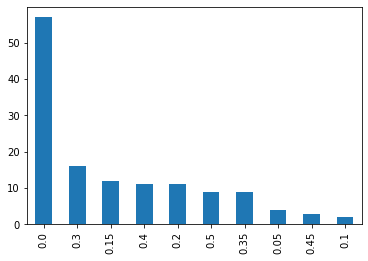

In [341]:
df_new['Discount'].value_counts().plot(kind='bar')

###### 1.What price point is most effective at maximizing sales?

In [256]:
df_Pantene = df_new.query("Product=='Pantene'")
df_Pantene.loc[df_Pantene['Sales $'].idxmax()]
# 3.99 which is 50% discount of the original price is the most effective price to maximize sales

Year                    2021
week                      12
Product              Pantene
Price                   3.99
On Flyer?                Yes
Discount                 0.5
Units                  58297
Sales $            232605.03
Gross Margin $      -6412.67
Num_Transact           26439
Sales/Transact        8.7978
Margin/Transact    -0.242546
Cost                     4.1
Name: 11, dtype: object

In [257]:
df_Aussie = df_new.query("Product=='Aussie'")
df_Aussie.loc[df_Aussie['Sales $'].idxmax()]
#2.49 which is 50% discount of the original price is the most effective price to maximize sales

Year                   2021
week                     39
Product              Aussie
Price                  2.49
On Flyer?               Yes
Discount                0.5
Units                 77200
Sales $            192228.0
Gross Margin $     -23932.0
Num_Transact          22396
Sales/Transact      8.58314
Margin/Transact   -1.068584
Cost                    2.8
Name: 105, dtype: object

###### 2.What price point is most effective at maximizing gross margin?

In [258]:
df_new.groupby('Product')['Gross Margin $'].max()

Product
Aussie     28248.22
Pantene    35631.74
Name: Gross Margin $, dtype: float64

In [259]:
df_Pantene.loc[df_Pantene['Gross Margin $'].idxmax()]
# 6.79 which is 15% discount of the original price is the most effective price point to maximize gross margin

Year                   2021
week                     35
Product             Pantene
Price                  6.79
On Flyer?               Yes
Discount               0.15
Units                 13246
Sales $            89940.34
Gross Margin $     35631.74
Num_Transact          12130
Sales/Transact     7.414702
Margin/Transact    2.937489
Cost                    4.1
Name: 34, dtype: object

In [260]:
df_Aussie.loc[df_Aussie['Gross Margin $'].idxmax()]
# 3.99 which is 20% discount of the original price is the most effective price point to maximize gross margin

Year                   2021
week                     18
Product              Aussie
Price                  3.99
On Flyer?               Yes
Discount                0.2
Units                 23738
Sales $            94714.62
Gross Margin $     28248.22
Num_Transact          17558
Sales/Transact     5.394385
Margin/Transact    1.608852
Cost                    2.8
Name: 84, dtype: object

###### 3.Is Shampoo seasonal (influenced by time of year)? Explain why or why not.

In [261]:
from datetime import datetime, timedelta
df_new['Year'][0]
df_new['week'][0]
date = str(df_new['Year'][0]) + '-W' + str(df_new['week'][0])
res = datetime.strptime(date + '-1', "%Y-W%W-%w")
res

datetime.datetime(2021, 1, 4, 0, 0)

In [262]:
total_num = len(df_new['Year']) 
period = []
for i in range(total_num):
    df_new['Year'][i]
    df_new['week'][i]
    date = str(df_new['Year'][i]) + '-W' + str(df_new['week'][i])
    res = datetime.strptime(date + '-1', "%Y-W%W-%w")
    period.append(str(res))

df_new['Period'] = period
df_new['Period'] = df_new['Period'].apply(pd.to_datetime)
df_new.head()

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460,8.150556,3.968168,4.1,2021-01-04
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983,7.436048,3.253909,4.1,2021-01-11
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117,6.917586,1.751447,4.1,2021-01-18
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038,7.714584,3.491647,4.1,2021-01-25
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379,8.069147,3.928533,4.1,2021-02-01


In [263]:
from datetime import datetime
import datetime as dt
from datetime import date
def monthly(x):
    return dt.datetime(x.year,x.month, 1)

In [264]:
df_new['Month']= df_new['Period'].apply(monthly)
df_new.head()

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
0,2021,1,Pantene,7.99,No,0.00,8630,68953.70,33570.70,8460,8.150556,3.968168,4.1,2021-01-04,2021-01-01
1,2021,2,Pantene,7.29,Yes,0.10,10183,74234.07,32483.77,9983,7.436048,3.253909,4.1,2021-01-11,2021-01-01
2,2021,3,Pantene,5.49,Yes,0.30,21568,118408.32,29979.52,17117,6.917586,1.751447,4.1,2021-01-18,2021-01-01
3,2021,4,Pantene,7.49,Yes,0.05,9309,69724.41,31557.51,9038,7.714584,3.491647,4.1,2021-01-25,2021-01-01
4,2021,5,Pantene,7.99,No,0.00,8462,67611.38,32917.18,8379,8.069147,3.928533,4.1,2021-02-01,2021-02-01


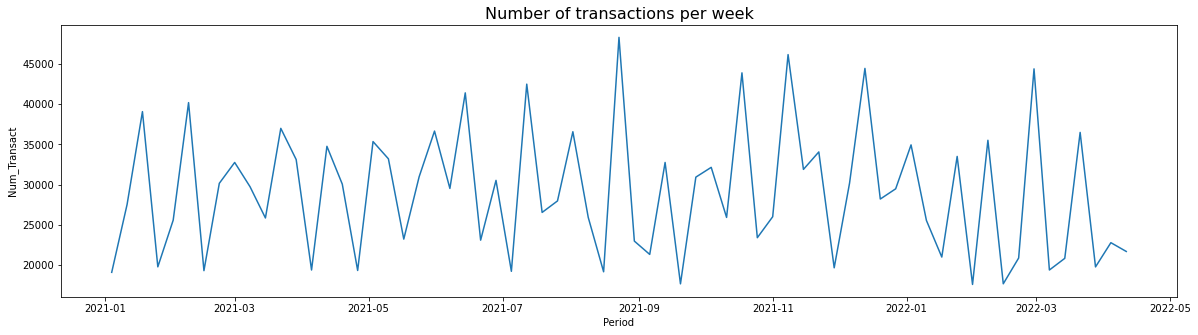

In [265]:
# no seasonality detected. continuous sales
import matplotlib.pyplot as plt 
import seaborn as sns
df_new_sales_trend_period = pd.DataFrame(df_new.groupby('Period')['Num_Transact'].sum())
plt.figure(figsize=(20,5))
sns.lineplot(x = df_new_sales_trend_period.index, y = df_new_sales_trend_period['Num_Transact'])
plt.title("Number of transactions per week",fontsize = 16)
plt.show()

###### No seasonality detected. continuous sales

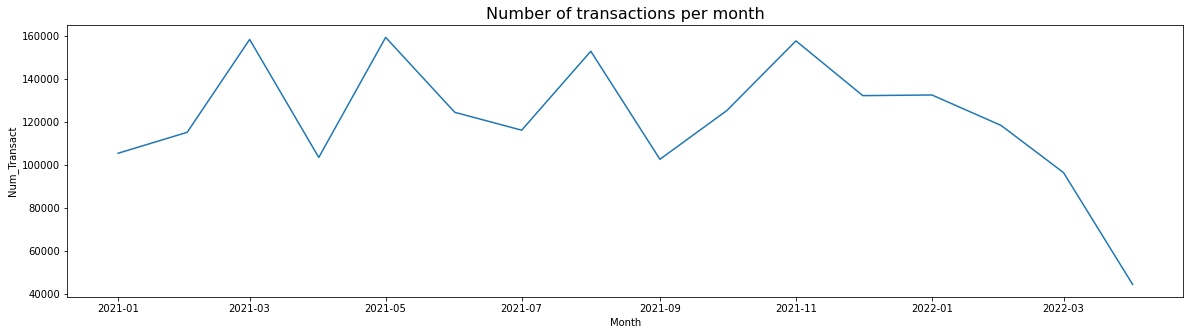

In [266]:

import matplotlib.pyplot as plt 
import seaborn as sns
plt.figure(figsize=(20,5))
df_new_sales_trend_mon = pd.DataFrame(df_new.groupby('Month')['Num_Transact'].sum())
sns.lineplot(x = df_new_sales_trend_mon.index, y = df_new_sales_trend_mon['Num_Transact'])
plt.title("Number of transactions per month",fontsize = 16)
plt.show()

###### 4.What is the cost per unit of each product?

In [267]:
pantene_cost = df_Pantene['Cost'][0]
df_new.groupby('Product')['Cost'].mean()
# Cost of Aussie is $2.8 each
# Cost of Pantene is $4.1 each

Product
Aussie     2.798734
Pantene    4.100000
Name: Cost, dtype: float64

###### 5.How would Pantene perform for units, sales and margin with a 25% discount?

In [268]:
df_Pantene_20 = df_Pantene.query("Discount == 0.2")
df_Pantene_30 = df_Pantene.query("Discount == 0.3")
df_Pantene_20_30 = pd.concat([df_Pantene_20,df_Pantene_30])
df_Pantene_20_30

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost
19,2021,20,Pantene,6.49,Yes,0.2,14099,91502.51,33696.61,12691,7.210032,2.655158,4.1
28,2021,29,Pantene,6.49,Yes,0.2,14378,93313.22,34363.42,12691,7.352708,2.707700,4.1
42,2021,43,Pantene,6.49,Yes,0.2,14239,92411.11,34031.21,12447,7.424368,2.734089,4.1
2,2021,3,Pantene,5.49,Yes,0.3,21568,118408.32,29979.52,17117,6.917586,1.751447,4.1
17,2021,18,Pantene,5.49,Yes,0.3,21995,120752.55,30573.05,17795,6.785757,1.718070,4.1
29,2021,30,Pantene,5.49,Yes,0.3,21363,117282.87,29694.57,17117,6.851836,1.734800,4.1
30,2021,31,Pantene,5.49,No,0.3,18339,100681.11,25491.21,14838,6.785356,1.717968,4.1
50,2021,51,Pantene,5.49,Yes,0.3,21576,118452.24,29990.64,17456,6.785761,1.718071,4.1
52,2022,1,Pantene,5.49,Yes,0.3,21157,116151.93,29408.23,17117,6.785764,1.718072,4.1
53,2022,2,Pantene,5.49,No,0.3,18338,100675.62,25489.82,14694,6.851478,1.734709,4.1


In [269]:
#Pantene's performance on units, sales, gross margin at 25% of discount
# Option 1 - the total units, sales, gross margins of 20% and 30% then divided by 2
def sum_variable(df,x):
    print(df.groupby('Product')[x].sum()/2)
pantene_attribute = ['Units','Sales $','Gross Margin $']
sum_variable(df_Pantene_20_30,pantene_attribute)

           Units    Sales $  Gross Margin $
Product                                    
Pantene  93526.0  534815.74       151359.14


In [270]:
def mean_variable(df,x):
    print(df.groupby('Discount')[x].mean())
pantene_attribute2 = ['Units','Sales/Transact','Margin/Transact']
mean_variable(df_Pantene,pantene_attribute2)

                 Units  Sales/Transact  Margin/Transact
Discount                                               
0.00       8636.214286        8.218387         4.001192
0.05       9371.000000        7.689710         3.480390
0.10      10183.000000        7.436048         3.253909
0.15      12882.571429        7.394484         2.929479
0.20      14238.666667        7.329036         2.698982
0.30      20619.428571        6.823363         1.727591
0.35      27942.000000        6.876951         1.546989
0.40      32604.600000        6.978616         1.005270
0.45      41056.333333        7.963820         0.691735
0.50      56170.875000        8.619854        -0.237640


In [271]:
def sum_variable2(df,x):
    print(df.groupby('Discount')[x].sum())
sum_variable2(df_Pantene,pantene_attribute2)

           Units  Sales/Transact  Margin/Transact
Discount                                         
0.00      241814      230.114834       112.033380
0.05       28113       23.069130        10.441169
0.10       10183        7.436048         3.253909
0.15       90178       51.761385        20.506351
0.20       42716       21.987108         8.096947
0.30      144336       47.763538        12.093136
0.35       55884       13.753902         3.093978
0.40      163023       34.893079         5.026352
0.45      123169       23.891461         2.075205
0.50      449367       68.958832        -1.901121


In [272]:
df_Pantene_avg_units = pd.DataFrame(df_Pantene.groupby('Discount')['Units'].mean())
Pantene_20_units = df_Pantene_avg_units['Units'][df_Pantene_avg_units['Units'].index ==0.20].to_list()[0]
Pantene_30_units = df_Pantene_avg_units['Units'][df_Pantene_avg_units['Units'].index ==0.30].to_list()[0]
Pantene_25_units = (Pantene_30_units + Pantene_20_units)/2
Pantene_25_units

17429.04761904762

In [273]:
#Option2 use average sales, average sales/transac and average margin/transac to calculate 25%
pantene_25 = {}
pantene_attribute2 = ['Units','Sales/Transact','Margin/Transact']
len(pantene_attribute2)
for x in pantene_attribute2:
    df_Pantene_avg = pd.DataFrame(df_Pantene.groupby('Discount')[x].mean())
    Pantene_20_avg= df_Pantene_avg[x][df_Pantene_avg[x].index==0.2].to_list()[0]
    Pantene_30_avg = df_Pantene_avg[x][df_Pantene_avg[x].index==0.3].to_list()[0]
    Pantene_25_avg = (Pantene_20_avg + Pantene_30_avg)/2
    pantene_25[x]=Pantene_25_avg
print(pantene_25)


{'Units': 17429.04761904762, 'Sales/Transact': 7.076199267339493, 'Margin/Transact': 2.213286656880737}


In [274]:
pantene_25

{'Units': 17429.04761904762,
 'Sales/Transact': 7.076199267339493,
 'Margin/Transact': 2.213286656880737}

In [275]:
pantene_25_sales = pantene_25['Units']*pantene_25['Sales/Transact']
pantene_25_margin = pantene_25['Units']*pantene_25['Margin/Transact']
pantene_25_dict2 = {'Sales $':pantene_25_sales,'Gross Margin $':pantene_25_margin}
print(pantene_25_dict2)

{'Sales $': 123331.41399232988, 'Gross Margin $': 38575.47853737707}


In [276]:
pantene_25_dict2.update(pantene_25)
print(pantene_25_dict2)

{'Sales $': 123331.41399232988, 'Gross Margin $': 38575.47853737707, 'Units': 17429.04761904762, 'Sales/Transact': 7.076199267339493, 'Margin/Transact': 2.213286656880737}


In [277]:
#Pantene's performance on units, sales, gross margin at 25% of discount
df_pantene_25_data = pd.DataFrame(pantene_25_dict2,index  = [1,2,3,4,5])
df_pantene_25_data.head(1)

,Sales $,Gross Margin $,Units,Sales/Transact,Margin/Transact
1,123331.413992,38575.478537,17429.047619,7.076199,2.213287


In [278]:
pantene_25_dict2['Discount'] = 0.25
from collections import OrderedDict
key_order= ['Discount', 'Sales $', 'Gross Margin $', 'Units', 'Sales/Transact','Margin/Transact']
d= OrderedDict(pantene_25_dict2)
for k in key_order: 
    d.move_to_end(k)
print(d)

OrderedDict([('Discount', 0.25), ('Sales $', 123331.41399232988), ('Gross Margin $', 38575.47853737707), ('Units', 17429.04761904762), ('Sales/Transact', 7.076199267339493), ('Margin/Transact', 2.213286656880737)])


###### 6.How would Pantene perform for units, sales and margin with a 60% discount?

In [279]:
df_Pantene_avg_data = pd.DataFrame(df_Pantene.groupby('Discount')[['Units','Sales/Transact','Margin/Transact']].mean()).reset_index()
df_Pantene_avg_data

,Discount,Units,Sales/Transact,Margin/Transact
0,0.00,8636.214286,8.218387,4.001192
1,0.05,9371.000000,7.689710,3.480390
2,0.10,10183.000000,7.436048,3.253909
3,0.15,12882.571429,7.394484,2.929479
4,0.20,14238.666667,7.329036,2.698982
5,0.30,20619.428571,6.823363,1.727591
6,0.35,27942.000000,6.876951,1.546989
7,0.40,32604.600000,6.978616,1.005270
8,0.45,41056.333333,7.963820,0.691735
9,0.50,56170.875000,8.619854,-0.237640


In [280]:
def growth_rate(a):
    sales_growth_rate = [0,]
    for p1 in range(9):
        p2 = (df_Pantene_avg_data[a][p1+1]-df_Pantene_avg_data[a][p1])/df_Pantene_avg_data[a][p1]
        sales_growth_rate.append(p2)
    return sales_growth_rate

In [281]:
def growth_delta(b):
    sales_delta = [0,]
    for p1 in range(9):
        p2 = df_Pantene_avg_data[b][p1+1]-df_Pantene_avg_data[b][p1]
        sales_delta.append(p2)
    return sales_delta

In [282]:
u = growth_rate('Units')
st = growth_rate('Sales/Transact')
mt = growth_rate('Margin/Transact')
u_d = growth_delta('Units')
st_d = growth_delta('Sales/Transact')
mt_d = growth_delta('Margin/Transact')

In [283]:
df_Pantene_avg_data['Unit_growth_rate']=u
df_Pantene_avg_data['Sales/Transact_growth_rate']= st
df_Pantene_avg_data['Margin/Transact_growth_rate']= mt
df_Pantene_avg_data['Unit_growth_delta'] = u_d
df_Pantene_avg_data['Sales/Transact_growth_delta'] = st_d
df_Pantene_avg_data['Margin/Transact_growth_delta'] = mt_d
df_Pantene_avg_data

,Discount,Units,Sales/Transact,Margin/Transact,Unit_growth_rate,Sales/Transact_growth_rate,Margin/Transact_growth_rate,Unit_growth_delta,Sales/Transact_growth_delta,Margin/Transact_growth_delta
0,0.00,8636.214286,8.218387,4.001192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.05,9371.000000,7.689710,3.480390,0.085082,-0.064329,-0.130162,734.785714,-0.528677,-0.520803
2,0.10,10183.000000,7.436048,3.253909,0.086650,-0.032987,-0.065073,812.000000,-0.253662,-0.226481
3,0.15,12882.571429,7.394484,2.929479,0.265106,-0.005590,-0.099705,2699.571429,-0.041565,-0.324430
4,0.20,14238.666667,7.329036,2.698982,0.105266,-0.008851,-0.078682,1356.095238,-0.065448,-0.230496
5,0.30,20619.428571,6.823363,1.727591,0.448129,-0.068996,-0.359910,6380.761905,-0.505673,-0.971392
6,0.35,27942.000000,6.876951,1.546989,0.355130,0.007854,-0.104540,7322.571429,0.053588,-0.180602
7,0.40,32604.600000,6.978616,1.005270,0.166867,0.014783,-0.350176,4662.600000,0.101665,-0.541719
8,0.45,41056.333333,7.963820,0.691735,0.259219,0.141175,-0.311892,8451.733333,0.985204,-0.313535
9,0.50,56170.875000,8.619854,-0.237640,0.368142,0.082377,-1.343542,15114.541667,0.656034,-0.929375


In [284]:
pantene_60 = []
for c in ['Units','Sales/Transact','Margin/Transact']:
    v = df_Pantene_avg_data[c][9]+(df_Pantene_avg_data[c][9]-df_Pantene_avg_data[c][7])
    pantene_60.append(v)
print(pantene_60)

[79737.15, 10.261092372229983, -1.4805504936790022]


In [285]:
pantene_60.append(pantene_60[0]*pantene_60[1])
pantene_60.append(pantene_60[0]*pantene_60[2])
pantene_60

[79737.15,
 10.261092372229983,
 -1.4805504936790022,
 818190.261648358,
 -118054.87679705664]

In [286]:
pantene_60_dict = {'Discount':0.06,'Sales $':pantene_60[3],'Gross Margin $':pantene_60[4],'Units':pantene_60[0],'Sales/Transact':pantene_60[1],'Margin/Transact':pantene_60[2]}
pantene_60_data = pd.DataFrame(pantene_60_dict,index = [1,2,3,4,5,6])
pantene_60_data.head(1)


,Discount,Sales $,Gross Margin $,Units,Sales/Transact,Margin/Transact
1,0.06,818190.261648,-118054.876797,79737.15,10.261092,-1.48055


In [287]:
df_Pantene_summary = df_Pantene.groupby('Discount').agg({'Sales $':'sum','Gross Margin $':'sum','Units':'mean','Sales/Transact':'mean','Margin/Transact':'mean'})
df_Pantene_summary['Sequence'] = [1,2,3,4,5,6,7,8,9,10]
df_Pantene_summary = df_Pantene_summary.reset_index()
df_Pantene_summary.set_index('Sequence',inplace = True)
df_Pantene_summary

,Discount,Sales $,Gross Margin $,Units,Sales/Transact,Margin/Transact
Sequence,,,,,,
1,0.00,1932093.86,940656.46,8636.214286,8.218387,4.001192
2,0.05,210566.37,95303.07,9371.000000,7.689710,3.480390
3,0.10,74234.07,32483.77,10183.000000,7.436048,3.253909
4,0.15,612308.62,242578.82,12882.571429,7.394484,2.929479
5,0.20,277226.84,102091.24,14238.666667,7.329036,2.698982
6,0.30,792404.64,200627.04,20619.428571,6.823363,1.727591
7,0.35,295626.36,66501.96,27942.000000,6.876951,1.546989
8,0.40,780880.17,112485.87,32604.600000,6.978616,1.005270
9,0.45,553028.81,48035.91,41056.333333,7.963820,0.691735


In [288]:
df_Pantene_summary1 = df_Pantene_summary.append(pantene_60_data.head(1))

In [289]:
df_Pantene_summary2 = df_Pantene_summary1.append(df_pantene_25_data.head(1))

In [290]:
df_Pantene_summary2.fillna(0.25,inplace = True)

In [291]:
df_Pantene_summary2['Sequence']= [1,2,3,4,5,7,8,9,10,11,12,6]
df_Pantene_summary3 = df_Pantene_summary2.sort_values(by='Sequence')
df_Pantene_summary3

,Discount,Sales $,Gross Margin $,Units,Sales/Transact,Margin/Transact,Sequence
1,0.00,1.932094e+06,940656.460000,8636.214286,8.218387,4.001192,1
2,0.05,2.105664e+05,95303.070000,9371.000000,7.689710,3.480390,2
3,0.10,7.423407e+04,32483.770000,10183.000000,7.436048,3.253909,3
4,0.15,6.123086e+05,242578.820000,12882.571429,7.394484,2.929479,4
5,0.20,2.772268e+05,102091.240000,14238.666667,7.329036,2.698982,5
1,0.25,1.233314e+05,38575.478537,17429.047619,7.076199,2.213287,6
6,0.30,7.924046e+05,200627.040000,20619.428571,6.823363,1.727591,7
7,0.35,2.956264e+05,66501.960000,27942.000000,6.876951,1.546989,8
8,0.40,7.808802e+05,112485.870000,32604.600000,6.978616,1.005270,9
9,0.45,5.530288e+05,48035.910000,41056.333333,7.963820,0.691735,10


In [292]:
df_Pantene_summary4 = df_Pantene_summary3.set_index('Sequence')
#units,sales/transact,margin/transact are average value
#sales and gross margin are the total value

###### Overview of Pantene on 25% discount and 60% discount

In [293]:
df_Pantene_summary_final = df_Pantene_summary4.rename(columns ={'Units':'Avg_Units','Sales/Transact':'Avg_Sales/Transact','Margin/Transact':'Avg_Margin/Transact'})
df_Pantene_summary_final

,Discount,Sales $,Gross Margin $,Avg_Units,Avg_Sales/Transact,Avg_Margin/Transact
Sequence,,,,,,
1,0.00,1.932094e+06,940656.460000,8636.214286,8.218387,4.001192
2,0.05,2.105664e+05,95303.070000,9371.000000,7.689710,3.480390
3,0.10,7.423407e+04,32483.770000,10183.000000,7.436048,3.253909
4,0.15,6.123086e+05,242578.820000,12882.571429,7.394484,2.929479
5,0.20,2.772268e+05,102091.240000,14238.666667,7.329036,2.698982
6,0.25,1.233314e+05,38575.478537,17429.047619,7.076199,2.213287
7,0.30,7.924046e+05,200627.040000,20619.428571,6.823363,1.727591
8,0.35,2.956264e+05,66501.960000,27942.000000,6.876951,1.546989
9,0.40,7.808802e+05,112485.870000,32604.600000,6.978616,1.005270


In [294]:
df_new_onflyer = df_new.groupby('On Flyer?')['Units','Sales $','Gross Margin $'].sum()
df_new_onflyer

C:\Users\nim\AppData\Local\Temp/ipykernel_20180/1344346986.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_new_onflyer = df_new.groupby('On Flyer?')['Units','Sales $','Gross Margin $'].sum()


,Units,Sales $,Gross Margin $
On Flyer?,,,
No,861550,4720937.1,1.883077e+06
Yes,2150150,8743937.7,1.396930e+06


##### 7.What impact does being “On Flyer” have on performance?

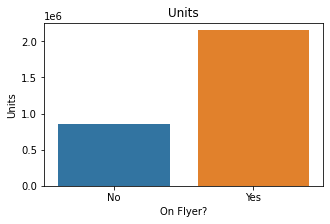

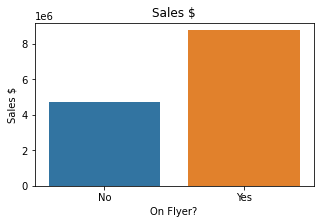

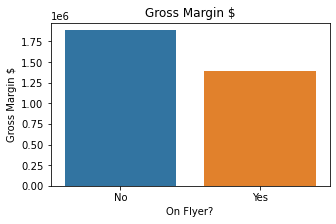

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt
list_attribute = ['Units','Sales $','Gross Margin $']
for v in list_attribute:
    plt.figure(figsize = (5,3))
    sns.barplot(x=df_new_onflyer.index,y = v, data =df_new_onflyer)
    plt.title(v)
    plt.show()

###### 8.	Client wants to change the price on an upcoming Aussie Shampoo flyer promotion. Her goal is to maximize sales, but she does not want to sacrifice too much margin.

In [296]:
df_Aussi_right_discount = df_Aussie.groupby('Discount').agg({'Units':'sum','Sales $':'sum','Gross Margin $':'sum','Num_Transact':'sum','Sales/Transact':'mean','Margin/Transact':'mean'})
df_Aussi_right_discount

,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact
Discount,,,,,,
0.00,316371,1578691.29,692852.490000,306389,5.153468,2.261742
0.05,11529,55223.91,22942.710000,11303,4.885775,2.029789
0.10,12630,56708.70,21339.947228,11254,5.038982,1.896210
0.15,77185,331123.65,116320.697513,63159,5.242500,1.841642
0.20,179182,714936.18,213226.580000,132541,5.402718,1.611337
0.30,320846,1119752.54,221383.740000,181374,6.186040,1.223028
0.35,325414,1070612.06,159452.860000,143049,7.490591,1.115620
0.40,342560,1024254.40,65086.400000,133689,7.661899,0.486877
0.50,77200,192228.00,-23932.000000,22396,8.583140,-1.068584


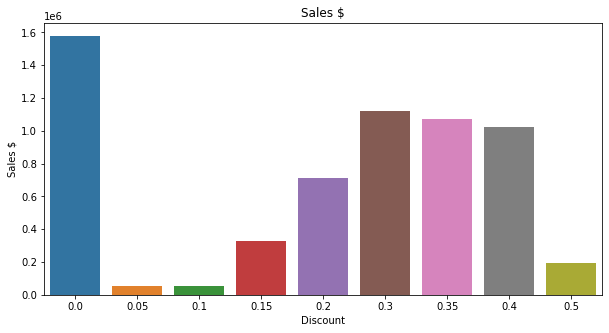

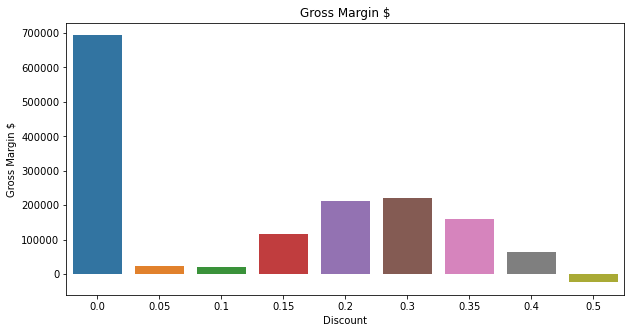

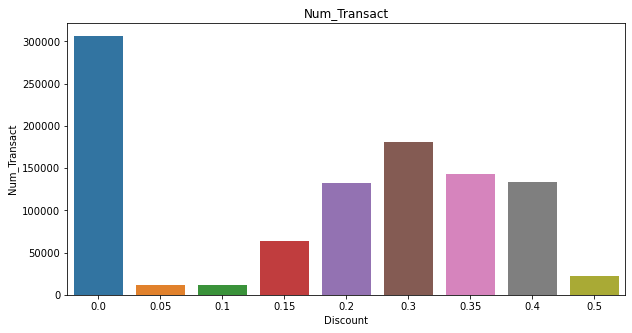

In [297]:
#Can remove Aussie from promotion, because sales, margin and number of transactions are the highest when Aussie has no discount.
# If Aussie is on the flyer for promotion, choose 30% discount
import seaborn as sns
import matplotlib.pyplot as plt
list_attribute = ['Sales $','Gross Margin $','Num_Transact']
for v in list_attribute:
    plt.figure(figsize = (10,5))
    sns.barplot(x=df_Aussi_right_discount.index,y = v, data =df_Aussi_right_discount)
    plt.title(v)
    plt.show()

In [298]:
price = df_Aussie.query("Discount==0.3")['Price'].mean()
description = "Price of Aussie at 30% discount is at: "
print(f'{description}{price}')

Price of Aussie at 30% discount is at: 3.490000000000001


###### Aussie Shampoo sold at $2.49 is a “loss leader” promotion. We lose money selling it at this price, but hope that people who came to buy it will purchase other items.

In [300]:
df_Aussie.query("Discount==0.5")

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost
105,2021,39,Aussie,2.49,Yes,0.5,77200,192228.0,-23932.0,22396,8.58314,-1.068584,2.8


In [307]:
df_new_2 = df_new.groupby(['Discount','Product']).agg({'Price':'mean','Units':'sum','Sales $':'sum','Gross Margin $':'sum','Num_Transact':'sum','Sales/Transact':'mean','Margin/Transact':'mean'})
df_new_2.sort_values(by='Num_Transact',ascending=False)


Price   Units     Sales $  Gross Margin $  Num_Transact  \
Discount Product                                                            
0.00     Aussie    4.99  316371  1578691.29   692852.490000        306389   
         Pantene   7.99  241814  1932093.86   940656.460000        235099   
0.50     Pantene   3.99  449367  1792974.33   -49430.370000        207985   
0.30     Aussie    3.49  320846  1119752.54   221383.740000        181374   
0.35     Aussie    3.29  325414  1070612.06   159452.860000        143049   
0.40     Aussie    2.99  342560  1024254.40    65086.400000        133689   
0.20     Aussie    3.99  179182   714936.18   213226.580000        132541   
0.30     Pantene   5.49  144336   792404.64   200627.040000        116134   
0.40     Pantene   4.79  163023   780880.17   112485.870000        111897   
0.15     Pantene   6.79   90178   612308.62   242578.820000         82834   
0.45     Pantene   4.49  123169   553028.81    48035.910000         69464   
0.15     Aussie    4.29   77185   331123.65   116320.697513         63159   
0.35     Pantene   5.29   55884   295626.36    66501.960000         42988   
0.20     Pantene   6.49   42716   277226.84   102091.240000         37829   
0.05     Pantene   7.49   28113   210566.37    95303.070000         27382   
0.50     Aussie    2.49   77200   192228.00   -23932.000000         22396   
0.05     Aussie    4.79   11529    55223.91    22942.710000         11303   
0.10     Aussie    4.49   12630    56708.70    21339.947228         11254   
         Pantene   7.29   10183    74234.07    32483.770000          9983   

                  Sales/Transact  Margin/Transact  
Discount Product                                   
0.00     Aussie         5.153468         2.261742  
         Pantene        8.218387         4.001192  
0.50     Pantene        8.619854        -0.237640  
0.30     Aussie         6.186040         1.223028  
0.35     Aussie         7.490591         1.115620  
0.40     Aussie         7.661899         0.486877  
0.20     Aussie         5.402718         1.611337  
0.30     Pantene        6.823363         1.727591  
0.40     Pantene        6.978616         1.005270  
0.15     Pantene        7.394484         2.929479  
0.45     Pantene        7.963820         0.691735  
0.15     Aussie         5.242500         1.841642  
0.35     Pantene        6.876951         1.546989  
0.20     Pantene        7.329036         2.698982  
0.05     Pantene        7.689710         3.480390  
0.50     Aussie         8.583140        -1.068584  
0.05     Aussie         4.885775         2.029789  
0.10     Aussie         5.038982         1.896210  
         Pantene        7.436048         3.253909

In [308]:
df_new_2.sort_values(by='Sales $',ascending=False)

,,Price,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact
Discount,Product,,,,,,,
0.00,Pantene,7.99,241814,1932093.86,940656.460000,235099,8.218387,4.001192
0.50,Pantene,3.99,449367,1792974.33,-49430.370000,207985,8.619854,-0.237640
0.00,Aussie,4.99,316371,1578691.29,692852.490000,306389,5.153468,2.261742
0.30,Aussie,3.49,320846,1119752.54,221383.740000,181374,6.186040,1.223028
0.35,Aussie,3.29,325414,1070612.06,159452.860000,143049,7.490591,1.115620
0.40,Aussie,2.99,342560,1024254.40,65086.400000,133689,7.661899,0.486877
0.30,Pantene,5.49,144336,792404.64,200627.040000,116134,6.823363,1.727591
0.40,Pantene,4.79,163023,780880.17,112485.870000,111897,6.978616,1.005270
0.20,Aussie,3.99,179182,714936.18,213226.580000,132541,5.402718,1.611337


In [318]:
df_new[df_new['Sales $']==df_new['Sales $'].max()]

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
11,2021,12,Pantene,3.99,Yes,0.5,58297,232605.03,-6412.67,26439,8.7978,-0.242546,4.1,2021-03-22,2021-03-01


In [319]:
df_new[df_new['Gross Margin $']==df_new['Gross Margin $'].max()]

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
34,2021,35,Pantene,6.79,Yes,0.15,13246,89940.34,35631.74,12130,7.414702,2.937489,4.1,2021-08-30,2021-08-01


In [320]:
df_new[df_new['Num_Transact']==df_new['Num_Transact'].max()]

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
11,2021,12,Pantene,3.99,Yes,0.5,58297,232605.03,-6412.67,26439,8.797800,-0.242546,4.1,2021-03-22,2021-03-01
49,2021,50,Pantene,3.99,Yes,0.5,56076,223743.24,-6168.36,26439,8.462621,-0.233305,4.1,2021-12-13,2021-12-01


###### Aussie is NOT a effetive "loss leader" in promotion. When Aussie is on 50% discount, the margin is negative and sales $ is low.
the maximum sales, gross margin and number of transactions all happened when Pantene is on promotion.


###### Your director proposes to change the promotion to 2 for $5 or pay 2.99 each, hoping that this will improve margin. Will this work? Explain why or why not.

In [322]:
df_new_2.sort_values(by='Gross Margin $',ascending=False)

Price   Units     Sales $  Gross Margin $  Num_Transact  \
Discount Product                                                            
0.00     Pantene   7.99  241814  1932093.86   940656.460000        235099   
         Aussie    4.99  316371  1578691.29   692852.490000        306389   
0.15     Pantene   6.79   90178   612308.62   242578.820000         82834   
0.30     Aussie    3.49  320846  1119752.54   221383.740000        181374   
0.20     Aussie    3.99  179182   714936.18   213226.580000        132541   
0.30     Pantene   5.49  144336   792404.64   200627.040000        116134   
0.35     Aussie    3.29  325414  1070612.06   159452.860000        143049   
0.15     Aussie    4.29   77185   331123.65   116320.697513         63159   
0.40     Pantene   4.79  163023   780880.17   112485.870000        111897   
0.20     Pantene   6.49   42716   277226.84   102091.240000         37829   
0.05     Pantene   7.49   28113   210566.37    95303.070000         27382   
0.35     Pantene   5.29   55884   295626.36    66501.960000         42988   
0.40     Aussie    2.99  342560  1024254.40    65086.400000        133689   
0.45     Pantene   4.49  123169   553028.81    48035.910000         69464   
0.10     Pantene   7.29   10183    74234.07    32483.770000          9983   
0.05     Aussie    4.79   11529    55223.91    22942.710000         11303   
0.10     Aussie    4.49   12630    56708.70    21339.947228         11254   
0.50     Aussie    2.49   77200   192228.00   -23932.000000         22396   
         Pantene   3.99  449367  1792974.33   -49430.370000        207985   

                  Sales/Transact  Margin/Transact  
Discount Product                                   
0.00     Pantene        8.218387         4.001192  
         Aussie         5.153468         2.261742  
0.15     Pantene        7.394484         2.929479  
0.30     Aussie         6.186040         1.223028  
0.20     Aussie         5.402718         1.611337  
0.30     Pantene        6.823363         1.727591  
0.35     Aussie         7.490591         1.115620  
0.15     Aussie         5.242500         1.841642  
0.40     Pantene        6.978616         1.005270  
0.20     Pantene        7.329036         2.698982  
0.05     Pantene        7.689710         3.480390  
0.35     Pantene        6.876951         1.546989  
0.40     Aussie         7.661899         0.486877  
0.45     Pantene        7.963820         0.691735  
0.10     Pantene        7.436048         3.253909  
0.05     Aussie         4.885775         2.029789  
0.10     Aussie         5.038982         1.896210  
0.50     Aussie         8.583140        -1.068584  
         Pantene        8.619854        -0.237640

When Aussie was at $2.99, the margin was listed in the top least at the bottom.

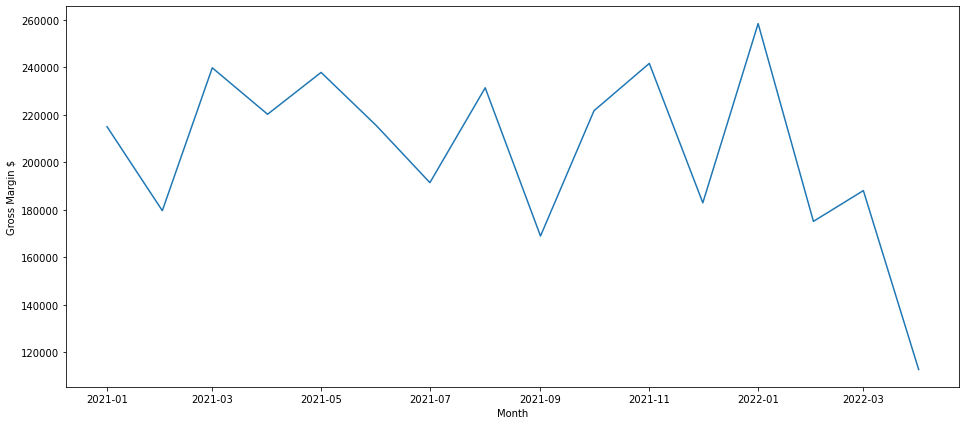

In [329]:
df_new_monthly_margin = pd.DataFrame(df_new.groupby('Month')['Gross Margin $'].sum())
plt.figure(figsize=(16,7))
sns.lineplot(x = df_new_monthly_margin.index, y = df_new_monthly_margin['Gross Margin $'])
plt.show()
#2022-01 has the highest sales

In [330]:
df_new_monthly_margin[df_new_monthly_margin['Gross Margin $'] == df_new_monthly_margin['Gross Margin $'].max()]

,Gross Margin $
Month,
2022-01-01,258415.323608


In [332]:
df_new.query("Month =='2022-01-01'")

,Year,week,Product,Price,On Flyer?,Discount,Units,Sales $,Gross Margin $,Num_Transact,Sales/Transact,Margin/Transact,Cost,Period,Month
52,2022,1,Pantene,5.49,Yes,0.30,21157,116151.93,29408.230000,17117,6.785764,1.718072,4.100000,2022-01-03,2022-01-01
53,2022,2,Pantene,5.49,No,0.30,18338,100675.62,25489.820000,14694,6.851478,1.734709,4.100000,2022-01-10,2022-01-01
54,2022,3,Pantene,7.99,No,0.00,8381,66964.19,32602.090000,8216,8.150461,3.968122,4.100000,2022-01-17,2022-01-01
55,2022,4,Pantene,4.79,Yes,0.40,33436,160158.44,23070.840000,22641,7.073824,1.018985,4.100000,2022-01-24,2022-01-01
56,2022,5,Pantene,7.99,No,0.00,8714,69624.86,33897.460000,8379,8.309447,4.045526,4.100000,2022-01-31,2022-01-01
119,2022,1,Aussie,3.29,No,0.35,41463,136413.27,20316.870000,17825,7.652918,1.139796,2.800000,2022-01-03,2022-01-01
120,2022,2,Aussie,4.99,No,0.00,11413,56950.87,24994.470000,10869,5.239753,2.299611,2.800000,2022-01-10,2022-01-01
121,2022,3,Aussie,4.29,Yes,0.15,15493,66464.97,23348.533608,12802,5.191765,1.823819,2.782962,2022-01-17,2022-01-01
122,2022,4,Aussie,4.99,No,0.00,10978,54780.22,24041.820000,10869,5.040042,2.211962,2.800000,2022-01-24,2022-01-01
123,2022,5,Aussie,4.99,No,0.00,9701,48407.99,21245.190000,9239,5.239527,2.299512,2.800000,2022-01-31,2022-01-01


- The maximum discount on Aussie in the month which has highest margin is 35%. The price was $3.29.

In [339]:
df_Aussie_price_margin = pd.DataFrame(df_Aussie.groupby(['Discount','Price']).agg({'Gross Margin $':'sum','Gross Margin $':'mean'}))
df_Aussie_price_margin2= df_Aussie_price_margin.reset_index()
df_Aussie_price_margin2

,Discount,Price,Gross Margin $
0,0.00,4.99,23891.465172
1,0.05,4.79,22942.710000
2,0.10,4.49,21339.947228
3,0.15,4.29,23264.139503
4,0.20,3.99,26653.322500
5,0.30,3.49,24598.193333
6,0.35,3.29,22778.980000
7,0.40,2.99,10847.733333
8,0.50,2.49,-23932.000000


<AxesSubplot:xlabel='Price', ylabel='Gross Margin $'>

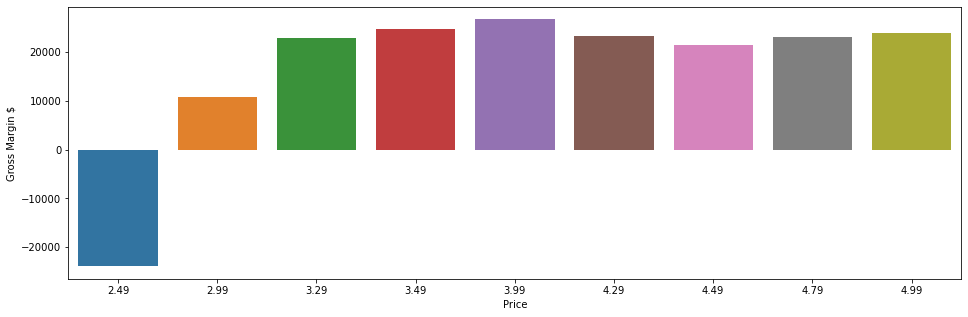

In [340]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(x=df_Aussie_price_margin2['Price'],y = 'Gross Margin $', data = df_Aussie_price_margin2)

When Aussie was at discount, the margin is bad. There's no way to increase margin by having 40% discount on Aussie